## **Notebook 12: Demystifying Gaussian Processes**
### CBE 512. Machine Learning in Chemical Science and Engineering.

&#169; Princeton University

Gaussian Processes (GPs) are a probabilistic approach used for modeling complex functions and making predictions with a measure of uncertainty. At their core, GPs rely on the concept of using distributions over functions to represent possible values of an unknown function across different inputs. Key facets of GPs involve:
  
1.   ***Defining Functions as Distributions***: Unlike deterministic methods that predict a single function, GPs assume a distribution over possible functions. Specifically, GPs treat every point in a function as a random variable, and any collection of points follows a joint Gaussian distribution.
2.  ***Covariance Function (Kernel)***: The kernel or covariance function is central to GPs. It encodes assumptions about the function, such as smoothness, by defining the relationship between function values at different points. This kernel allows us to estimate the correlation between nearby points in the function, capturing the degree of similarity based on distance.

In the following cells, we are going to gain some intuition for what all this actually means and why it's important/useful

<ipython-input-3-62ed3e123734>:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  mycmap = plt.cm.get_cmap('winter', nsamples)  # define a color map for samples


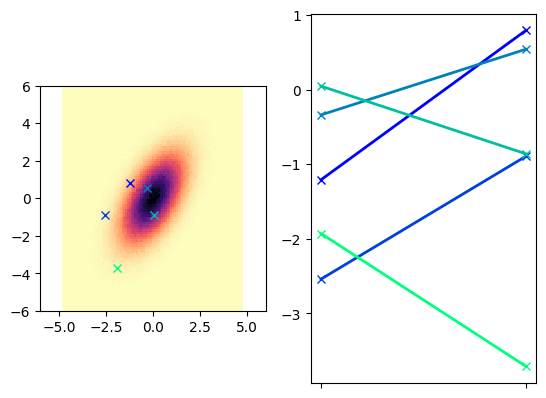

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Set up a random number generator
rng = np.random.default_rng()

# Define the number of dimensions and samples
ndim = 2  # dimension of each sample vector
nsamples = 5  # number of samples to draw

# Define the Gaussian distribution parameters
mean = np.zeros(ndim)  # zero mean vector
cov = np.array([[1, 0.8], [0.8, 2]])  # covariance matrix with correlation

# Draw `nsamples` random vectors from the defined multivariate Gaussian distribution
samples = rng.multivariate_normal(mean, cov, nsamples)

# Generate a large number of samples to visualize the "true" distribution as a background
x1t, x2t = rng.multivariate_normal(mean, cov, 1000000).T  # draw 1,000,000 samples
fig, ax = plt.subplots(1, 2)  # create two subplots side-by-side

# Plot the true distribution as a 2D histogram in the first subplot
ax[0].hist2d(x1t, x2t, bins=(100, 100), cmap=plt.cm.magma_r)

# Overlay the individual drawn samples on top of the 2D histogram
mycmap = plt.cm.get_cmap('winter', nsamples)  # define a color map for samples
myColors = [mycmap(i / (nsamples - 1.)) for i in range(nsamples)]  # generate colors for each sample
for i, sample in enumerate(samples):
    ax[0].plot(sample[0], sample[1], linestyle='none', marker='x', color=myColors[i], linewidth=5)

# Adjust plot limits and appearance for the first subplot
ax[0].axis('square')
ax[0].set_xlim([-6, 6])
ax[0].set_ylim([-6, 6])

# Represent each sample in a different form: as lines in the second subplot
# Here, each line connects the coordinates of each sample vector (one in each dimension)
xrvs = [dim / (ndim - 1.) for dim in range(ndim)]  # set x positions for line plot
for i, sample in enumerate(samples):
    ax[1].plot(xrvs, sample, linestyle='-', marker='x', color=myColors[i], linewidth=2)

# Customize x-axis for the second subplot (no tick labels for simplicity)
ax[1].xaxis.set_ticks(xrvs)
ax[1].xaxis.set_ticklabels([])

# Display the plots
plt.show()


Now, we will follow this up for a more complex situation of 30-dimensional Gaussian, of course we will not show the underlying distribution but only show the samples. We will choose to represent the covariance as
$$k(x_i,x_j) = \exp \left[-\frac{(x_i-x_j)^2}{2} \right]$$

<ipython-input-6-4c7638f9faa8>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  mycmap = plt.cm.get_cmap('gist_rainbow', nsamples)


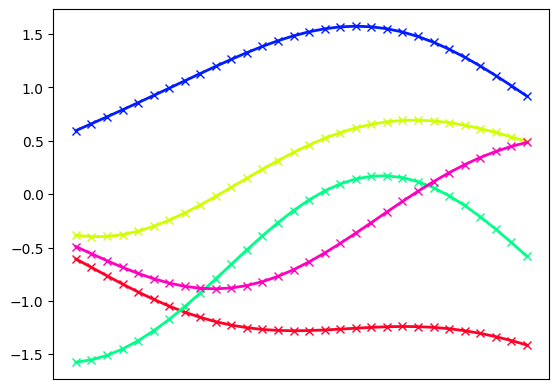

In [6]:
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

# Define a Gaussian covariance kernel function based on Euclidean distance
def covkernel(xi, xj, l=1.0):
    # Compute the pairwise Euclidean distances between points in `xi` and `xj`
    dij = cdist(xi, xj, metric='euclidean')
    # Return the covariance matrix using the Gaussian (RBF) kernel formula
    return np.exp(-0.5 * (dij ** 2) / (l ** 2))

# Set up parameters
ndim = 30          # number of dimensions (variables)
nsamples = 5       # number of samples to draw
length_scale = 0.5  # length scale parameter for the kernel
xrvs = np.linspace(0, 1, ndim)[:, np.newaxis]  # evenly spaced points over [0,1], reshaped for compatibility

# Define a color map for different samples
mycmap = plt.cm.get_cmap('gist_rainbow', nsamples)
myColors = [mycmap(i / (nsamples - 1.)) for i in range(nsamples)]  # distinct color for each sample

# Define the Gaussian Process distribution and draw samples
mean = np.zeros(ndim)                   # zero mean vector for the GP
Xij = covkernel(xrvs, xrvs, l=length_scale)  # compute covariance matrix based on kernel function
cov = Xij  # set covariance matrix (optional here, but retains clarity in case of future modifications)

# Sample from the multivariate normal distribution with defined mean and covariance
samples = rng.multivariate_normal(mean, cov, nsamples)

# Plot the samples as lines connecting points in each dimension
fig, axs = plt.subplots(1)
for i, sample in enumerate(samples):
    # Plot each sample as a line, marking individual dimensions
    axs.plot(xrvs, sample, linestyle='-', marker='x', color=myColors[i], linewidth=2)

# Configure x-axis to hide tick labels for simplicity
axs.xaxis.set_ticks(np.squeeze(xrvs).tolist())
axs.axes.get_xaxis().set_visible(False)  # hide the x-axis labels

# Display the plot
plt.show()

Now, let's see if we can generate a few "observations," and then sample the posterior. Let's assume our true function is something we know, like the Van der Waals equation of state:

$$P_r = \frac{8}{3}\frac{T_r}{V_r - \frac{1}{3}}-\frac{3}{V_r^2}$$

To keep this problem in a physically reasonable range, we will suppose $T_r = 0.85$ and examine $V_r$ over the range of 0.5 to 4. In the following, we can include fewer or more observations to illustrate how our uncertainty changes.

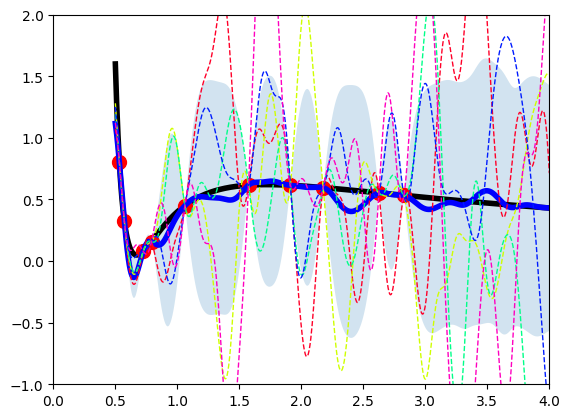

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Define the Van der Waals equation of state function
def vdw_P(Tr, Vr):
    # Computes pressure using the Van der Waals equation given Tr and Vr
    term1 = 8. * Tr / (3 * Vr - 1)
    term2 = 3.0 / (Vr ** 2)
    return term1 - term2

# Function to plot the true function and the sampled observations
def make_plot(Vs, Ps, x, y):
    fig, axs = plt.subplots(1)
    # Plot the true function (Van der Waals curve)
    axs.plot(Vs, Ps, linestyle='-', color='k', linewidth=4)
    # Plot observations as red points
    axs.plot(x[:, 0], y[:, 0], linestyle='none', marker='o', color='r', markersize=10)
    axs.set_xlim([0, 4])  # reasonable limits for Vr
    axs.set_ylim([-1, 2])  # reasonable limits for Pr
    return fig, axs

# Function to plot the posterior mean with confidence intervals
def make_plot_posterior(axs, fmean, fp, fm):
    # Fill the confidence interval between mean - std dev and mean + std dev
    axs.fill_between(xs[:, 0], fm, fp, alpha=0.2)
    # Plot posterior mean
    axs.plot(xs, fmean, linestyle='-', color='b', linewidth=4)

# Set parameters and compute the true function
Tr = 0.85  # reduced temperature for Van der Waals function
Vmin, Vmax = 0.5, 4  # range of Vr values for physically meaningful results
Vs = np.linspace(Vmin, Vmax, 1000)  # range of volumes for plotting
Ps = vdw_P(Tr, Vs)  # calculate Pr for each Vr in the range

# Generate random observations in a subinterval of the range
nobs = 10
x = Vmin + (Vmax - 1 - Vmin) * rng.random(nobs)  # sample points in [Vmin, Vmax-1]
x = x[:, np.newaxis]  # reshape for compatibility
y = vdw_P(Tr, x)  # calculate corresponding pressures for each observation
yavg = np.mean(y)  # mean of observed values, used as a prior mean

# Plot true function and observations
fig, axs = make_plot(Vs, Ps, x, y)

# Define test points over full interval for posterior prediction
xs = Vs[:, np.newaxis]

# Compute covariance matrices for the Gaussian Process
length = 0.1  # length scale for the covariance kernel
kxsx = covkernel(xs, x, l=length)  # covariance between test and observed points
kxx = covkernel(x, x, l=length)  # covariance between observed points
invkxx = np.linalg.inv(kxx)  # inverse of observed covariance matrix
kxsxs = covkernel(xs, xs, l=length)  # covariance between test points
kxxs = covkernel(x, xs, l=length)  # covariance between observed and test points

# Compute posterior mean and covariance
muf = yavg  # mean prior, based on ideal gas approximation
meanf = muf + kxsx @ invkxx @ (y - yavg)  # posterior mean adjustment from observations
covf = kxsxs - kxsx @ invkxx @ kxxs  # posterior covariance

# Sample from the posterior distribution
nsamples = 500  # number of posterior samples to generate
samples = rng.multivariate_normal(meanf[:, 0], covf, nsamples)  # draw samples from posterior

# Calculate mean and confidence bounds (mean ± 1 std dev) from the posterior samples
sample_mean = np.mean(samples, axis=0)
sample_std = np.std(samples, axis=0)
mean_plus = sample_mean + 1 * sample_std
mean_minus = sample_mean - 1 * sample_std

# Plot posterior mean and confidence interval
make_plot_posterior(axs, sample_mean, mean_plus, mean_minus)

# Plot a few individual samples from the posterior to illustrate variance
for i, sample in enumerate(samples[:5]):
    axs.plot(xs, sample, linestyle='--', color=myColors[i], linewidth=1)

plt.show()


The previous approach assumes noise-free observations and relies on a basic formulation that directly samples the posterior distribution. However, the posterior mean and variance can also be computed directly, as demonstrated in the next section

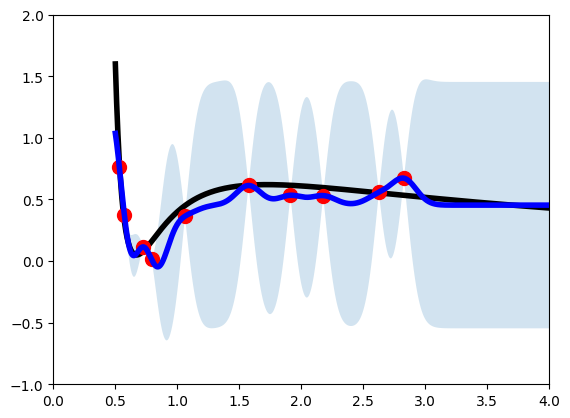

In [8]:
# Define noise level for new observations
sigma_n = 0.1

# Generate noisy observations based on the previous model
y = vdw_P(Tr, x) + rng.normal(loc=0, scale=sigma_n, size=nobs)[:, np.newaxis]  # Add noise to the previous observations
yavg = np.mean(y)  # Calculate the average of the noisy observations

# Define length scale for the covariance kernel
length = 0.1

# Compute the covariance matrices using the chosen kernel function with a specified length scale
kxsx = covkernel(xs, x, l=length)  # Covariance between test points xs and observed points x
kxx = covkernel(x, x, l=length)    # Covariance between observed points x
kxsxs = covkernel(xs, xs, l=length)  # Covariance between test points xs
kxxs = covkernel(x, xs, l=length)  # Covariance between observed points x and test points xs

# Perform Cholesky decomposition of the covariance matrix K(x,x)
L = np.linalg.cholesky(kxx)  # Cholesky decomposition of kxx

# Solve the linear system to find the 'alpha' vector
b = np.linalg.lstsq(L, y[:, 0] - yavg, rcond=None)[0]  # Solve L * b = (y - yavg)
alpha = np.linalg.lstsq(L.T, b, rcond=None)[0]  # Solve L.T * alpha = b

# Compute the posterior mean function
fmean = yavg + kxxs.T @ alpha  # Mean prediction

# Compute the posterior variance function
v = np.linalg.lstsq(L, kxxs, rcond=None)[0]  # Solve L * v = kxxs
fvar = np.diag(kxsxs - v.T @ v)  # Diagonal of the posterior covariance
fstd = np.sqrt(fvar)  # Standard deviation (square root of variance)

# Define upper and lower bounds for the posterior mean with 1 standard deviation
mean_plus = fmean + 1 * fstd  # Upper bound of posterior mean
mean_minus = fmean - 1 * fstd  # Lower bound of posterior mean

# Plotting the results
fig, axs = make_plot(Vs, Ps, x, y)  # Plot the noisy data and the model
make_plot_posterior(axs, fmean, mean_minus, mean_plus)  # Plot the posterior mean and bounds
plt.show()  # Display the plot


Next, we will replicate the previous exercise using the built-in Gaussian Process Regression (GPR) functions from the `scikit-learn` library. This approach simplifies the implementation by leveraging `scikit-learn`'s optimized routines, which handle key steps like covariance computation, Cholesky decomposition, and posterior prediction internally. By using `scikit-learn`, we gain access to a range of useful features, such as automatic optimization of kernel hyperparameters, streamlined handling of noise, and efficient computation for larger datasets. This will allow us to compare results and observe any differences in accuracy and efficiency compared to our custom implementation.

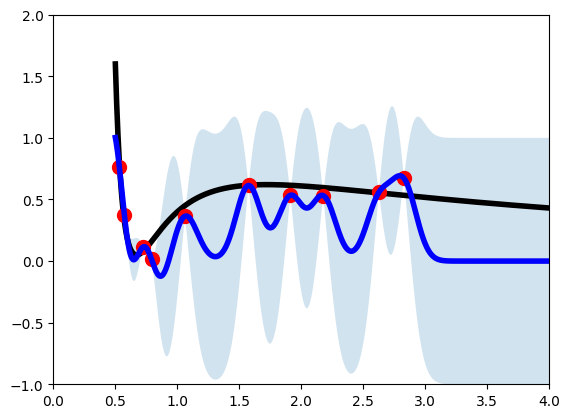

In [9]:
# Import the RBF (Radial Basis Function) kernel and Gaussian Process Regressor from scikit-learn
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor

# Define the RBF kernel with a fixed length scale of 0.1
the_kernel = RBF(length_scale=0.1, length_scale_bounds="fixed")

# Initialize the Gaussian Process Regressor with the specified kernel
the_model = GaussianProcessRegressor(kernel=the_kernel)

# Fit the model to the data (observations x and noisy targets y)
the_model.fit(x, y)

# Predict the mean and standard deviation of the function at the test points xs
fmean, fstd = the_model.predict(xs, return_std=True)

# Define the upper and lower bounds for one standard deviation above and below the mean
mean_plus = fmean + fstd
mean_minus = fmean - fstd

# Plotting the observations and the posterior distribution
fig, axs = make_plot(Vs, Ps, x, y)  # Plot original data (observed values)
make_plot_posterior(axs, fmean, mean_minus, mean_plus)  # Plot the posterior mean and confidence bounds
plt.show()


Note that using scikit-learn assumes a zero mean for the data by default, which suggests that we should normalize our data for accurate results. Recent versions of scikit-learn allow you to specify normalization within the Gaussian Process Regressor. However, it’s generally better to handle normalization explicitly to maintain a clear understanding of the data transformations. We’ll demonstrate this approach with some simple preprocessing...

1**2 * RBF(length_scale=0.1)
-21.326828180649024


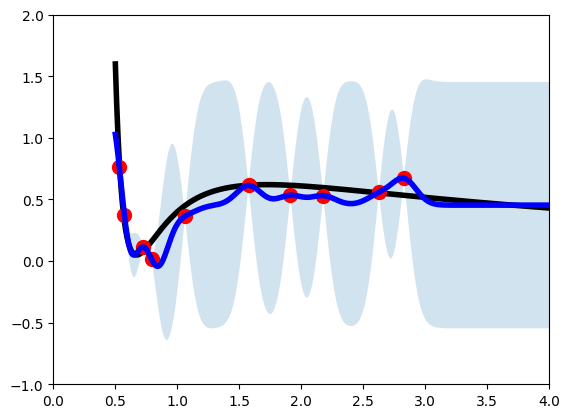

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,ConstantKernel
import numpy as np
import matplotlib.pyplot as plt

# Scale the target variable 'y' to have zero mean and unit variance
scaler = StandardScaler().fit(y)
yscaled = scaler.transform(y)

# Fit the model to the scaled data
kernel = ConstantKernel(1.0, constant_value_bounds="fixed")*\
  RBF(length_scale=0.1, length_scale_bounds="fixed")
#kernel = ConstantKernel(1.0, constant_value_bounds=(1e-5,100))*RBF(length_scale=0.1, length_scale_bounds=(1e-5,1000))
model = GaussianProcessRegressor(kernel=kernel, normalize_y=False,\
                                 alpha=1e-3,n_restarts_optimizer=50)
model.fit(x, yscaled)

print(model.kernel_)
print(model.log_marginal_likelihood_value_)
# Predict mean and standard deviation for new data points
fmean_scaled, fstd_scaled = model.predict(xs, return_std=True)

# Inverse transform the scaled predictions to the original scale
fmean = scaler.inverse_transform(fmean_scaled[:, np.newaxis])
mean_plus = scaler.inverse_transform(fmean_scaled[:, np.newaxis] + (1 / scaler.scale_) * fstd_scaled[:, np.newaxis])
mean_minus = scaler.inverse_transform(fmean_scaled[:, np.newaxis] - (1 / scaler.scale_) * fstd_scaled[:, np.newaxis])

# Plotting
fig, axs = make_plot(Vs, Ps, x, y)
make_plot_posterior(axs, np.squeeze(fmean), np.squeeze(mean_minus), np.squeeze(mean_plus))

# Display the plot
plt.show()
